또 어려서부터 성경을 알았나니 성경은 능히 너로 하여금 그리스도 예수 안에 있는 믿음으로 말미암아 구원에 이르는 지혜가 있게 하느니라 모든 성경은 하나님의 감동으로 된 것으로 교훈과 책망과 바르게 함과 의로 교육하기에 유익하니 이는 하나님의 사람으로 온전하게 하며 모든 선한 일을 행할 능력을 갖추게 하려 함이라 (딤후3:15-17)

-------

<center><img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/joyai/LectureNotes_ML.png?raw=true" width=1000></center>

__NOTE:__ The following materials have been compiled and adapted from the numerous sources including my own. Please help me to keep this tutorial up-to-date by reporting any issues or questions. Send any comments or criticisms to `idebtor@gmail.com` Your assistances and comments will be appreciated.


# Chapter 4. 경사하강법(Gradient Descent)

:본 단원은 참고문헌 (3) & (4)에서 대부분  발췌한 것입니다. 

--------------
경사하강법으로 학습하여 모델을 구하는 방법을 알아봅니다. 

__Review: Seaborn pairplot()__

- 시본(seaborn)의 pairplot을 이용하여 당뇨병 데이터셋에 있는 10개의 특성들의 상관관계를 모두 시각화하십시오. 다만, sex 특성을 hue를 사용하여 색으로 표시합니다. 

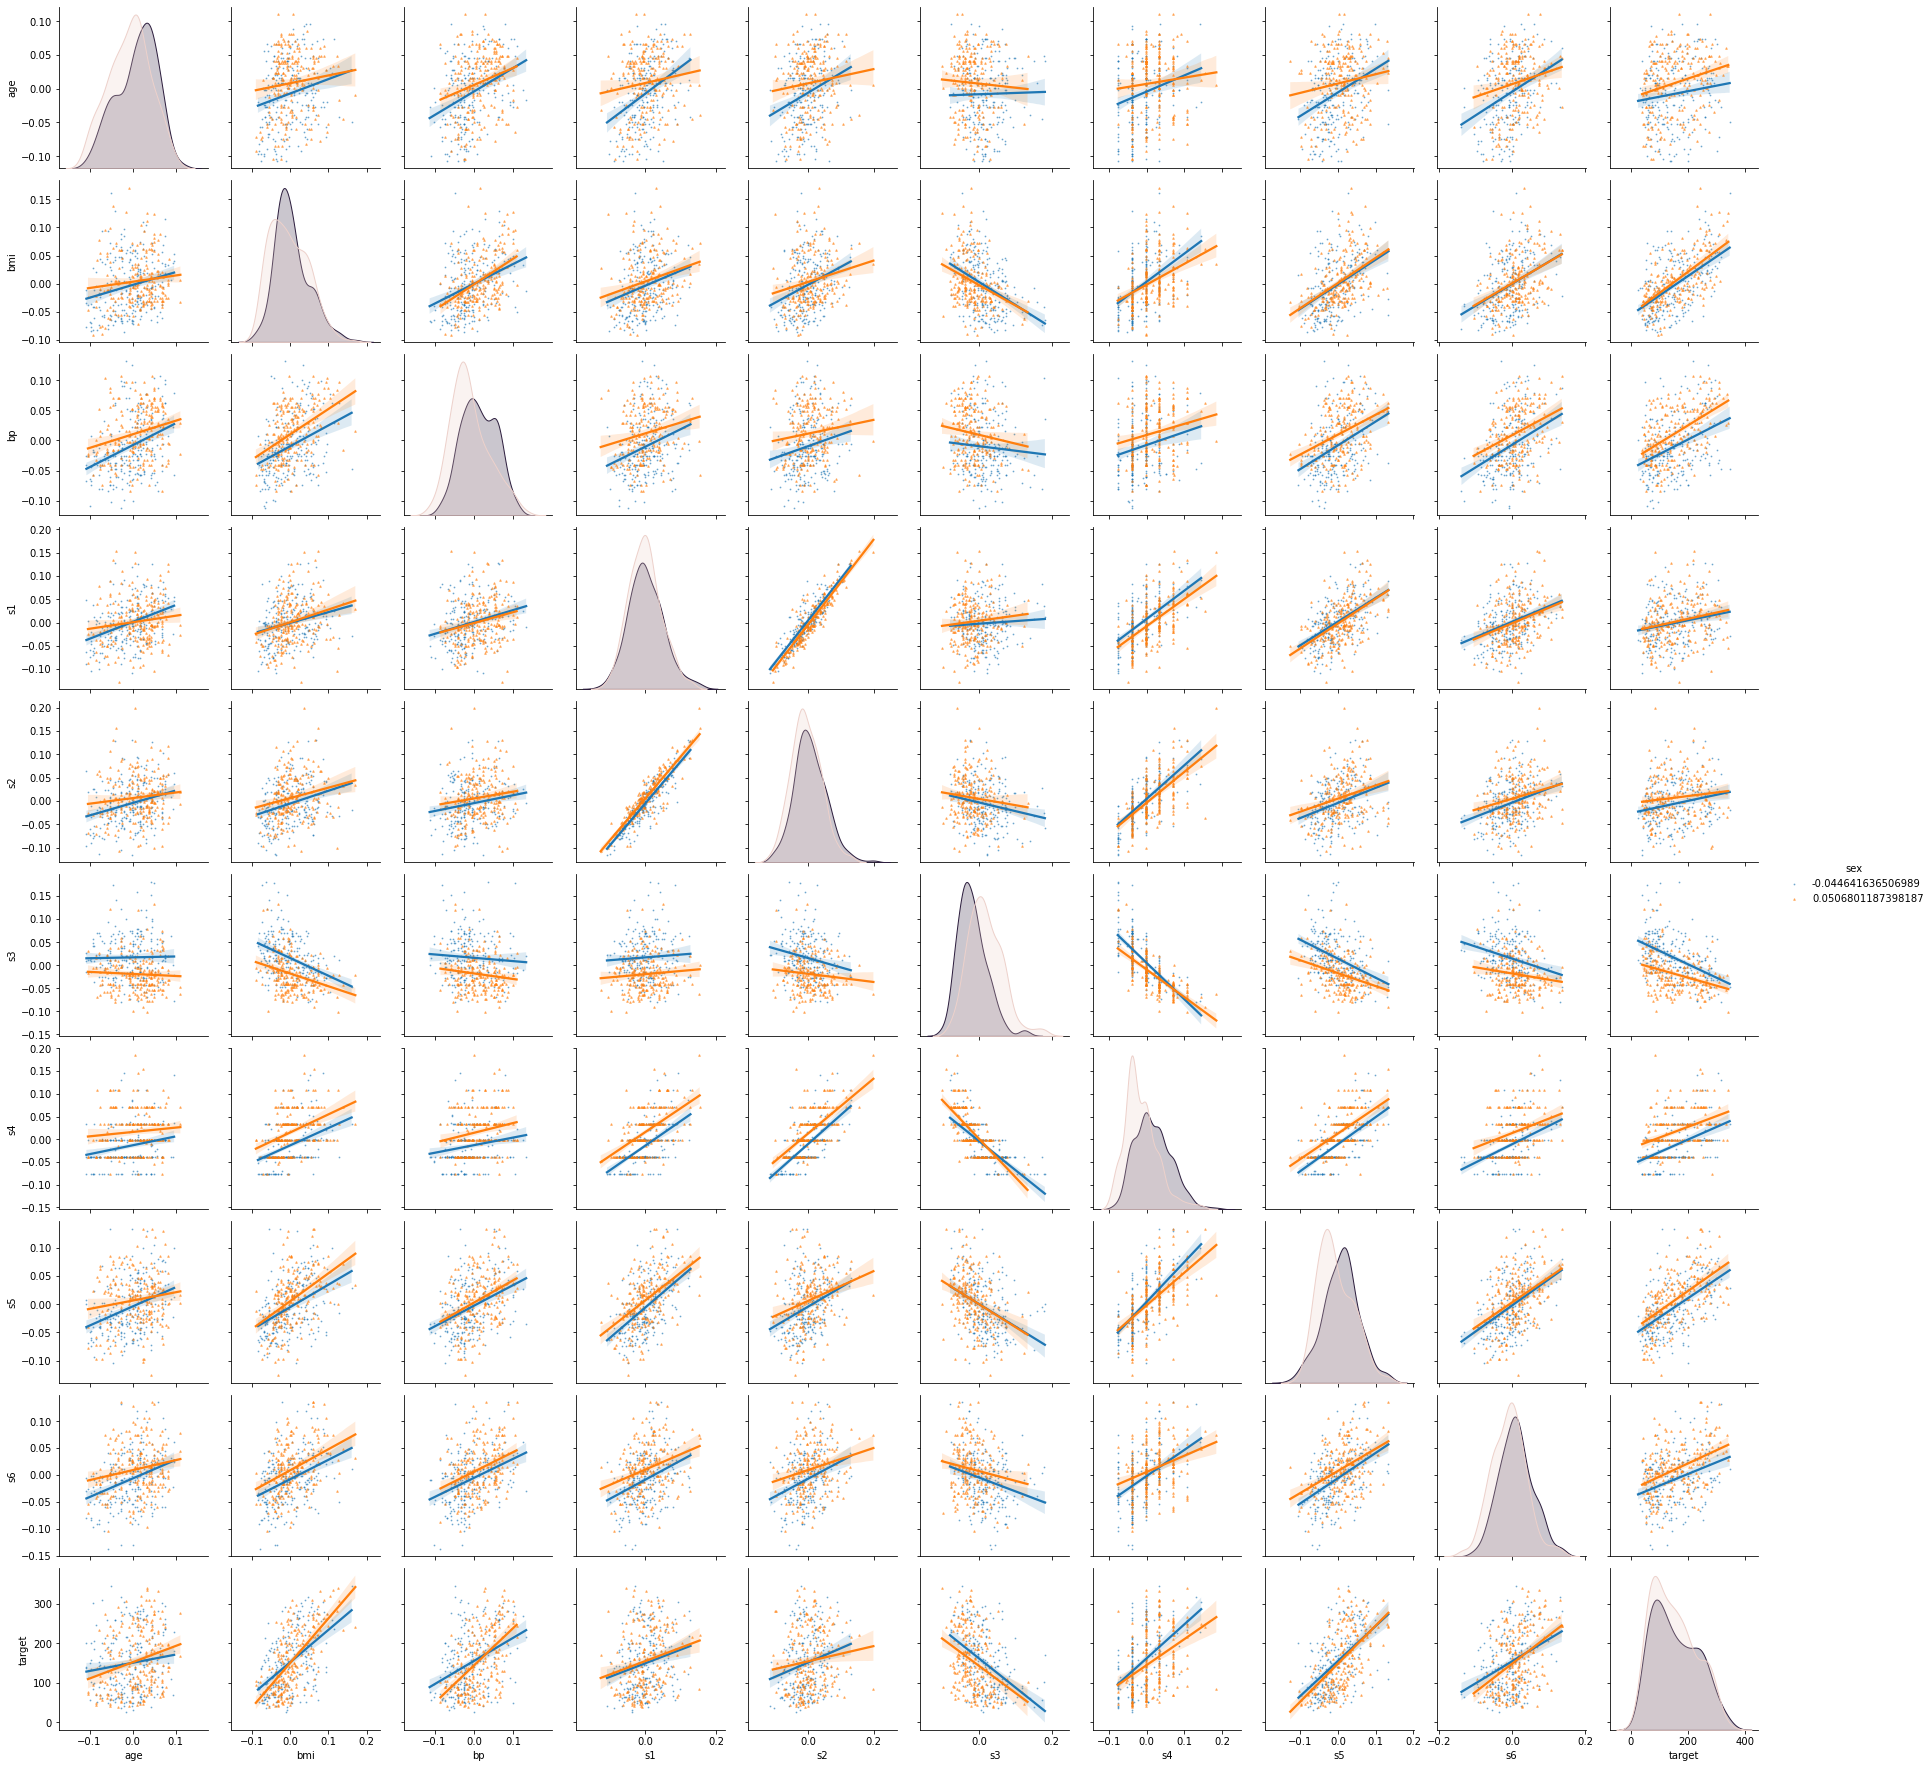

In [1]:
import seaborn as sns
import pandas as pd

from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df['target'] = pd.Series(diabetes.target)

sns.pairplot(data=df, kind='reg', hue='sex', markers=['.', '^'], plot_kws=dict(scatter_kws=dict(s=3, alpha=0.5)))

## 그래프로 경사하강법의 의미를 알아보기

앞에서 우리는 당뇨병 데이터셋에서 세 번째 특성과 타깃 값을 가지고 산점도를 그려 보았는데, 이 산점도를 대표하여 표현할 수 있는 직선을 그린다면 어떤 모양일까요?  다음 그림들 중에 하나를 선택해 보십시오. 어떤 직선이 데이터를 가장 잘 표현하고 있나요?

<table attr="center"><tr>
<td><img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/joyai/ai4all-diabetes3.png?raw=true", width=250></td> 
<td><img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/joyai/ai4all-diabetes4.png?raw=true", width=250/></td> 
<td><img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/joyai/ai4all-diabetes5.png?raw=true", width=250/></td> 
</tr></table>
<div style='text-align:center'>그림 1: 당뇨병 데이터셋(세 번째 특성) 산점도와 선형 회귀</div>

가운데 그림의 직선이 다른 두 그림의 직선들보다 더 잘 데이터셋을 표현한다는 것을 직감적으로 알 수 있습니다. 데이터들의 중심을 지나는 직선이 답이라는 것을 쉽게 알 수 있지만, 이 그래프는 10개의 특성들 중에 하나와 타깃(레이블)과의 산점도라는 것입니다. 만약 10개의 특성으로 그래프를 그린다면 어떻게 표현할 수 있을까요? 11차원의 그래프는 우리가 그릴 수도 없고, 그러한 공간을 상상할 수도 없습니다. 이렇게 상상할 수도 없는 다차원의 공간을 <span style="color:red"> 초평면(hyperplane)</span>이라고 부릅니다. 

그래서 대개 여러 개의 특성을 가진 데이터에서 특성의 개수를 한 두 개만 사용하여 2차원 혹은 3차원 그래프로 그려봅니다. 그러면, 제한적이긴 하지만, 알고리즘에 대한 직관을 쉽게 얻을 수 있게 됩니다. 항상 그런 것은 아니지만, 낮은 차원에서 얻은 직관은 높은 차원으로 확장될 수 있으므로, 위와 같이 입력 데이터의 특성을 한 개 골라 시각화하는 경우가 많습니다. 

### 선형 회귀와 경사 하강법의 관계를 이해하기
회귀 알고리즘의 목표는 산점도 그래프를 잘 표현하는 직선의 식을 찾는 것이었습니다. 즉 입력 데이터와 타깃 데이터를 통해 직선의 식을 찾는다는 것은 곧 기울기와 절편의 값을 찾는 것이었습니다. 

__경사 하강법(gradient descent)__ 이 바로 기울기와 절편의 값을 찾아가는 방법 중에 하나입니다. 경사 하강법은 모델이 데이터를 잘 표현할 수 있도록 기울기(변화율)를 사용하 모델을 조금씩 조정하는 최적화 알고리즘입니다. 경사 하강법이라는 최적화 알고리즘을 파이썬으로 이제 구현하려고 합니다. 그 전에 몇 가지 사전 지식이 필요합니다. 이 부분을 잘 이해하는 것이 중요합니다. 일단 이해하고 나면, 복잡한 계산은 컴퓨터가 알아서 해줄 것입니다. 


## 예측값 $\hat{y}$ 알아보기 

기계학습과 딥러닝 분야에서는 기울기 $a$를 종종 __가중치(weight)__ 를 의미하는 $w$나 계수를 의미하는 $\theta$로 표기합니다. 그리고, $y$는 $\hat{y}$로 표기하며 읽을 때는 와이-햇(y-hat)이라고 읽습니다. 절편(intercept)은 __편향(bias)__ 이라고 부릅니다. 즉, 앞으로는 $y = ax + b$로 표현했던 모델을 $\hat{y} = wx + b$로 표현할 것입니다. 

여기서 가중치 $w$와 편향 $b$는 알고리즘이 찾는 규칙을 의미하고, $\hat{y}$는 모델이 예측한 값(예측값, 출력)을 의미합니다. 가중치에 대해서는 나중에 더 깊이 알아보고, 지금은 예측값과 변화율에 집중하여 살펴보겠습니다. 

### 예측값이란 무엇일까요? 

우리가 입력과 출력 데이터$(x, y)$를 통해 규칙$(a, b)$을 발견하면 모델을 만들었다고 했습니다. 그 모델에 새로운 입력값을 넣으면, 어떤 출력이 나오는데, 이 값이 모델을 통해 예측한 값입니다. 

예를 들어 $y = 3x + 2$라는 모델의 $x$에 5를 넣으면 17이라는 값이 나오는데, 이 값이 모델을 통하여 예측한 값입니다. 그래서 타깃 데이터를 표현하는 $y$라는 문자와 구분하기 위해 $\hat{y}$이라는 문자를 따로 준비한 것입니다. 그러니까 $y$와 $\hat{y}$은 어떤 결과라는 점은 동일합니다. $\hat{y}$을 적용하여 모델에 관한 식을 다시 쓰면 다음과 같습니다. 

\begin{equation}
\hat{y} = wx + b \tag{1}
\end{equation}

이제 예측값의 의미를 이해했으니 예측값으로 어떻게 모델을 조정할 수 있는 알아보겠습니다. 

## 예측값으로 모델 찾아가기

위의 식(1)에서 우리가 찾고 싶은 것은 훈련 데이터 $(x, y)$를 잘 나타낼 수 있는 $w$와 $b$입니다. $W$와 $b$를 찾는 알고리즘은 다음과 같습니다. 

> __훈련 데이터에 적합한 가중치 $w$와 편향 $b$를 구하는 방법__
> 1. 무작위로 w와 b를 초기화한다. (무작위로 모델 만들기)
> 1. $x$에서 샘플 하나를 선택하여 $\hat{y}$을 계산한다. (무작위로 모델 예측하기)
> 1. $\hat{y}$과 선택한 샘플의 타깃(레이블) $y$를 비교한다. (예측한 값과 실제 값과 비교하기)
> 1. $\hat{y}$이 $y$와 더 가까워지도록 $w, b$를 조정한다. (모델 조정하기)
> 1. 모든 샘플을 처리할 때까지 다시 (2) ~ (4) 항목을 반복한다. 
>

위의 방법은 아주 직관적입니다. 

그런데, 항목(4) __$\hat{y}$이 $y$와 더 가까워지도록 $w, b$를 조정한다__ 는 어떤 의미일까요?  

일차함수와 같은 단순한 모델에서는 $w$와 $b$의 부호를 보고 $\hat{y}$이 커지거나 작아지는 방향을 짐작하기 쉽겠지만, 모델이 복잡해질수록 체계적인 방법이 필요합니다. 일단 위의 방법대로 모델을 한 번 조정해 보면서 어떤 체계적인 방법이 필요한지 알아보도록 합니다. 

### 훈련하기 준비 작업
앞 단원에서 미리 맛보기를 한 당뇨병 데이터셋을 다시 불러와서 그 중에 __세 번째 특성과 타깃(레이블)__ 데이터를 각각 $x, y$ 변수에 저장하여 작업을 준비합니다. 

In [3]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

x = diabetes.data[:,2]      # bmi feature 읽어오기 
y = diabetes.target         # target/label 읽어오기

변수 x, y의 형상이 각각 다음과 같은 것을 확인하십시오. 
```
(442,)
(442,)
```

In [4]:
print(x.shape)
print(y.shape)

(442,)
(442,)


### 훈련 데이터에 맞는 $w$와 $b$찾아보기

$w$와 $b$가 바뀌었을 때, $\hat{y}$이 어떻게 변하는지 알아내는 가장 간단한 방법은 실제로 계산을 해보는 것입니다. 

#### $w$와 $b$ 초기화 하기 

 $w$와 $b$를 무작위로 초기화합시다. 여기에서는 두 값을 모두 실수 1.0으로 정합니다. 쉽게 말해, 아직  $w$와 $b$를 어떻게 초기화할지 정하지 않았으므로, 임시적으로 1.0이라고 정한 것입니다. 물론, 이 방법은 $w$의 개수가 많아지면 번거롭기도 하고 바람직한 방법도 아닙니다. 
 
지금은 계산하기 쉬운 값 1.0으로 직접 정한 것입니다. 

In [9]:
w = 1.0
b = 1.0

In [6]:
x[:10]

array([ 0.06169621, -0.05147406,  0.04445121, -0.01159501, -0.03638469,
       -0.04069594, -0.04716281, -0.00189471,  0.06169621,  0.03906215])

In [7]:
y[:10]

array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310.])

#### 훈련 데이터의 첫 번째 샘플 데이터로 $\hat{y}$ 구하기

이제 임시로 만들 모델로 훈련 데이터의 첫 번째 샘플 `x[0]`에 대한 $\hat{y}$을 계산해 보겠습니다. 계산한 $\hat{y}$은 변수 `y_hat`변수에 저장합니다. 


In [10]:
y_hat = x[0] * w + b
print(y_hat)

1.0616962065186886


#### 타깃과 예측값 비교하기
에측값 `y_hat`을 구했으니, 이제 타깃값(레이블, 실제값)을 출력하여 비교합니다. 

In [11]:
print(y[0])
print(y_hat)

151.0
1.0616962065186886


#### $w$ 값을 조정해 예측값 바꾸기

우리가 예측한 `y_hat`은 1.06... 인데, 타깃은 151.0입니다. 차이가 많이 납니다. `w`와 `b`를 무작위 값으로 정했기 때문에 예측 결과가 잘 나오지 않은 것이 당연합니다.  이제 `w`와 `b`를 좀 더 바람직한 방향으로 바꾸어 보려고 합니다. 어떤 방향으로 바꾸면 `y_hat`이 `y[0]`에 가까워질 수 있을까요? 가장 쉬운 방법은 `w`와 `b`를 조금씩 변경해서 `y_hat`이 증가하는지 또는 감소하는지 살펴보는 것입니다.  

먼저 `w`를 0.1만큼 증가시키고 `y_hat`의 변화량을 관찰해 보십시오. 

In [12]:
w_inc = w + 0.1
y_hat_inc = x[0] * w_inc + b
print(y_hat_inc)

1.0678658271705574


`w`값을 0.1만큼 증가시킨 후에 $\hat{y}$을 다시 계산하여 `y_hat_inc`를 출력해보니 1.067...이므로, 그 전에 구한 `y_hat` 1.061...보다 조금 증가했습니다. 

#### $w$값 조정한 후, 예측값 증가 정도 확인하기 

그러면,`w`가 0.1만큼 증가했을 때, `y_hat`이 얼마나 증가했는지 계산해 보겠습니다. `y_hat`이 증가한 양을 `w`가 증가한 양으로 나누면 됩니다. 이것을 코딩으료 표현하면 다음과 같습니다. 

In [14]:
w_rate = (y_hat_inc - y_hat) / (w_inc - w)
print(w_rate)

0.061696206518688734


이렇게 계산한 값(0.616...)을 첫 번째 훈련 데이터 `x[0]`에 대한 __`w`의 변화율__이라고 합니다. 

<span style="color:blue"> 그런데, 신기하게도 `w_rate`에 대한 코드를 수식으로 적어서 정리하면, 변화율은 결국 훈련 데이터의 첫 번째 샘플인 `x[0]`이라는 것을 알 수 있습니다.</span>

\begin{align}
w_{rate} &= \frac{\hat{y}_{inc} - \hat{y}}{w_{inc} - w} \\
        &= \frac{(x[0] * w_{inc} + b) - (x[0] * w + b)}{w_{inc} - w}  \\
        &= \frac{x[0] * (w_{inc} - w)}{w_{inc}  - w} = x[0]
\end{align}


지금까지 계산한 것을 정리합니다. 

`y_hat`의 값은 타깃값 `y`보다 작으므로, `y_hat`을 증가시켜야 합니다. 이때 변화율은 양수이므로, `w`값을 증가시키면 `y_hat`값을 증가시킬 수 있습니다. (그래서, 우리는 0.1 정도 증가시켜서 계산해보았습니다) 

만약, 변화율이 음수일 때, `y_hat`을 증가시켜야 한다면 어떻게 해야 할까요? `w`값을 감소시키면 됩니다. 하지만, 이 방법은 변화율이 양수일 때와 음수일 때를 구분해야 하므로 번거롭습니다. 

다음 내용을 읽고 나면, 이 문제를 효율적으로 해결하는 방법이 바로 __변화율__ 그 자체라는 것을 알 수 있을 것입니다. 

## 변화율로 가중치 조정하기 

지금부터 `w`와 `b`를 변화율로 조정하는 방법을 알아봅니다. 먼저 `w`의 조정 방법을 알아보겠습니다. 

### 변화율이 양수일 때 가중치 조정하기
다음 그래프로는 변화율이 0보다 큰 경우를 가정한 그래프입니다. 

<center><img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/joyai/ai4all-diabetes6.png?raw=true" width="300"></center>
<center>그림 2: w가 증가하면 y_hat이 증가하는 경우(변화율이 양수일 때) </center>

앞에서 `y_hat`의 값은 타깃`y`보다 훨씬 작은 값이었습니다. 즉, `y_hat`이 더 많이 증가해야 하는 상황입니다. 이 상황에서 `w`가 증가하면 `y_hat`도 증가합니다. 이때 변화율이 양수인 점을 이용하여 __변화율을 `w`에 더하는 방법__으로 `w`를 증가시킬 수도 있습니다. 

### 변화율이 음수일 때 가중치 조정하기
그러면 변화율이 0보다 작을 때, `y_hat`을 증가시키려면 어떻게 해야 할까요? 다음은 변화율이 0보다 작은 직선의 식을 그림으로 나타낸 것입니다. 

<center><img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/joyai/ai4all-diabetes7.png?raw=true" width="300"></center>
<center>그림 3: w가 감소하면 y_hat이 증가하는 경우(변화율이 음수일 때) </center>

이 상황에서는 `w`가 증가하면, `y_hat`은 감소합니다. 반대로 말하면, `w`가 감소하면, `y_hat`은 증가합니다. 이때 변화율이 음수인 점을 이용하면, 앞에서 한 대로 변화율을 더하는 방법으로 `y_hat`의 값을 증가시킬 수 있습니다. 

두 경우 모두 `w`에 `w_rate`를 더하면 되는 것입니다! 계산이 아주 쉬워진 것이죠. __즉, 가중치 `w`를 조정하는 방법은 두 경우 모두 `w + w_rate`입니다.__  

다음은 가중치를 조정하는 예입니다. 

In [15]:
w_new = w + w_rate
print(w_new)

1.0616962065186888


In [16]:
w_new = w + x[0]
print(w_new)

1.0616962065186886


## 변화율로 편향 $b$ 조정하기 

이번에는 편향 $b$에 대한 변화율을 구한 다음, 변화율로 $b$를 조정하겠습니다. `b`를 0.1만큼 증가시킨 후, `y_hat`이 얼마나 증가했는지 계산하고 변화율도 계산합니다. 

In [ ]:
b_inc = None
y_hat_inc = None
print(y_hat_inc)

b_rate = None
print(b_rate)

변화율 b_rate을 보니 1입니다. 변화율이 1이라 함은 같이 움직인다는 것입니다. 편향이 1만큼 증가하면, `y_hat`도 1만큼 증가하고, 편향이 10만큼 증가하면, `y_hat`도 10만큼 증가한다는 것입니다. 이것은 수식으로도 증명이 됩니다. 

\begin{align}
b_{rate} &= \frac{\hat{y}_{inc} - \hat{y}}{b_{inc} - b} \\
        &= \frac{(x[0] * w + b_{inc}) - (x[0] * w + b)}{b_{inc} - b}  \\
        &= \frac{b_{inc}  - b}{b_{inc}  - b} = 1
\end{align}

<span style="color:blue"> 결론적으로 `b`를 조정하기 위해서는 변화율이 1이므로 단순히 1을 더하면 됩니다. </span>

In [ ]:
b_new = b + 1
print(b_new)

지금까지 실습에서는 `y_hat`을 증가시켜야 하는 상황을 가정하고 `w`와 `b`를 조정하는 방법에 대해 알아보았습니다. 그런데, 이 방법은 수동적인 방법입니다. 그 이유는 이 방법이 다음과 같은 상황에 대해 적합하게 대처하지 못하기 때문입니다. 

> - `y_hat`이 타깃(레이블) `y`에 한참 미치지 못하는 값인 경우, `w`와 `b`를 더 큰 폭으로 수정할 수 없습니다. (앞에서 변화율만큼 수정을 했지만, 그 외에 더 이상할 수 업습니다)
> - `y_hat`이 `y`보다 커지면 `y_hat`을 감소시키지 못합니다. 

어떻게 해야 이 문제를 해결할 수 있을까요?

다음 실습에서는 `w`와 `b`를 좀 더 능동적으로 조정하는 방법인 오차 역전파(backpropagation)에 대해 알아 보겠습니다. 

## 오차 역전파로 가중치와 편향을 조정하기

오차 역전파(backpropagation)는 $\hat{y}$과 $y$의 차이를 이용하여 `w`와 `b`를 조정합니다. 오차 역전파라는 이름에서 알 수 있듯이 이 방법은 오차가 연이어 전파되는 모습으로 수행됩니다. 아쉽게도 여기서 다룰 예제는 아주 간단해서 오차가 연이어 전파되는 모습이 잘 보이지 않습니다. 나중에 조금 더 복잡한 예제를 다룰 때, 오차가 연이어 전파되는 모습이 나오면 한 번 다루도록 하겠습니다. 

### 가중치와 편형을 더욱 적절하게 조정하기

앞의 예제에서는 __변화율__만으로 `w`와 `b`를 조정했습니다.  

- 만약, $\hat{y}$과 $y$의 차이가 크면 어떻게 해야 할까요? `w`와 `b`를 더 많이 증가시키면 되지 않을까요? 

- 또한 $\hat{y}$이 $y$보다 커져서 $\hat{y}$을 감소시켜야 한다면, 어떻게 해야 할까요? `w`와 `b`를 감소시켜야 하지 않을까요? 

- 이번에는 __$y$에서 $\hat{y}$을 뺀 오차의 양을 변화율에 곱하는 방법으로__ `w`를 조정해 보겠습니다. 이렇게 하면  $\hat{y}$이 $y$보다 많이 작은 경우, `w`와 `b`를 많이 바꿀 수 있습니다.  $\hat{y}$이 $y$를 지나치면 `w`와 `b`의 방향도 바꿔 줍니다. 이것을 수식으로 표현하면 다음과 같습니다. 

```
w_new = w + w_rate * (오차)
b_new = b + 1 * (오차)
```

#### 오차와 변화율을 곱하여 가중치 조정하기

먼저 `x[0]`일 때, `w`의 변화율과 `b`의 변화율에 __오차를 곱한__ 다음 조정된 `w_new`와 `b_new`를 출력해 보겠습니다. 결과값을 보면 `w`와 `b`가 각각 큰 폭으로 바뀌었음을 알 수 있습니다. 

In [ ]:
error = y[0] - y_hat
w_new = None
b_new = None
print(w_new, b_new)

#### 두 번째 샘플 x[1]을 사용하기

두 번째 샘플 `x[1]`을 사용하여 오차를 구하고 새로운 `w`와 `b`를 구해 보겠습니다. 

앞에서 `w_rate`식을 정리했을 때, 샘플값과 같아진다는 것을 알았으므로, 앞으로는 `w_rate`를 별도로 계산하지 않고, __샘플값을 그대로 사용합니다__. 즉, 여기서는 `x[1]`이 `w_rate`가 됩니다. 

In [ ]:
y_hat = x[1] * w_new + b_new
error = y[1] - y_hat
w_rate = x[1]
w_new = w_new + w_rate * error
b_new = b_new + 1 * error
print(w_new, b_new)

`w`는 4만큼 커지고 `b`는 절반(약 150에서 75로)으로 줄어 들었습니다. 이런 방식으로 모든 샘플을 사용해 가중치와 편향을 조정합니다. 

#### 전체 샘플을 반복하기

전체 샘플에 대해 앞의 과정을 반복하는 코드는 다음과 같습니다. 

In [ ]:
for x_i, y_i in zip(x, y):
    y_hat = None
    error = None
    w_rate = None
    w = None
    b = None
print(w, b)

파이썬의 zip()함수는 여러 개의 배열에서 동시에 요소를 하나씩 꺼내줍니다. 여기에서는 입력 x와 타깃 y 배열에서 요소를 하나씩 꺼내어 err를 계산하고 `w`와 `b`를 조정했습니다. 반복 구문 for를 사용하고 변수 이름만 달라졌을 뿐 이전과 동일합니다. 

#### 그래프 그려보기
지금까지 만든 모델이 전체 데이터셋을 잘 표현하는지 그래프를 그려 알아보겠습니다. 산점도 위에 `w`와 `b`를 사용한 직선을 그려보면 금방 알 수 있습니다. 직선 그래프를 그리려면 시작점과 종료점의 x, y좌료를 plot()함수에 전달하면 됩니다. x좌표 2개 `[-0.1, 0.15]` 를 지정하고, `y`좌표값은 `w`와 `b`를 사용해 계산하면 그래프를 그릴 수 있습니다. 

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x, y)
x0, x1 = None                 # set lower x, higher x in x-axis
y0, y1 = None        
plt.plot(None, None, 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

직선 모양이 어떤가요? 아주 만족스럽지는 않지만 산점도를 어느 정도 잘 표현한 것 같습니다. 어떻게 하면 조금 더 적합한 직선을 얻을 수 있을까요? 조금 더 반복해 볼까요? 

#### 여러 번 반복하기(epoch)

대개 경사 하강법에서는 주어진 훈련 데이터로 학습을 여러 번 반복합니다. 이렇게 전체 훈련 데이터를 모두 이용하여 한 단위의 작업을 진행하는 것을 특별히 epoch(에폭)이라고 부릅니다. 일반적으로 수십에서 수천 번의 에폭을 반복합니다. 100번의 epoch를 실행하면서 직선이 어떻게 이동하는지 확인해 보겠습니다. 우리가 할 일은 앞의 for문 바깥쪽에 for문을 하나 더 추가하는 것이 전부입니다. 

In [ ]:
for i in range(100):
    for x_i, y_i in zip(x, y):
        y_hat = x_i * w + b
        error = y_i - y_hat
        w_rate = x_i
        w = w + w_rate * error
        b = b + 1 * error
print(w, b)

100번의 에폭를 반복하여 찾은 `w`와 `b`는 약 913.6, 123.4 정도입니다. `w`와 `b`를 이용하여 이 직선을 그래프로 나타내면 다음과 같습니다. 

In [ ]:
plt.scatter(x, y)
x0, x1 = None                 # set lower x, higher x in x-axis
y0, y1 = None        
plt.plot(None, None, 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

직선이 전체 데이터를 대표할 만한 모양세를 갖추고 있습니다. 드디어 이 데이터에 잘 맞는 기계학습 모델을 찾았습니다. 

\begin{align}
\hat{y} = 913.6x + 123.4
\end{align}

### 모델로 예측하기

이번에는 입력 x에 없었던 새로운 데이터가 발생했다고 가정해 보겠습니다. 이 데이터에 대해 예측값을 얻으려면 어떻게 해야 할까요? 우리가 찾은 모델에 `x`를 넣고 계산하기만 하면 됩니다.  `x`가 0.18일 때, $\hat{y}$의 값을 예측해보겠습니다. 

In [ ]:
x_new = 0.18
y_pred = x_new * w + b
print(y_pred)

다음은 이 데이터를 산점도 위에 나타낸 것입니다. 


In [ ]:
plt.scatter(x, y)
plt.scatter(x_new, y_pred, color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

위 그래프에서 빨간 색으로 표시한 점이 바로 `x`가 0.18일 때 예측한 $\hat{y}$으로 찍은 점입니다. 산점도의 추세로 보니 어느 정도 잘 예측한 것으로 같죠? 축하합니다! 기계학습 모델로 예측까지 수행했습니다. 바로 이것이 기계학습이 하는 일입니다. 

다음은 지금까지 실습한 과정을 간단히 요약한 것입니다. 


> __지금까지는 모델을 이렇게 만들었습니다__
> 1. `w`와 `b`를 임의의 값(1.0, 1.0)으로 초기화하고, 훈련 데이터의 샘플을 하나씩 대입하여 $y$와 $\hat{y}$의 오차를 구합니다. 
> 2. 앞 단계에서 구한 오차를 `w`와 `b`의 변화율에 곱하고 이 값을 이용하여 `w`와 `b`를 조정합니다. 
> 3. 만약 $\hat{y}$이 $y$보다 커지면, 오차는 음수가 되어 자동으로 `w`와 `b`가 줄어들도록 조정이 됩니다. 
> 4. 반대로, $\hat{y}$이 $y$보다 작으면, 오차는 양수가 되고,  `w`와 `b`가 커지도록 조정이 됩니다

## Exercise 

### 모델로 예측하기

diabetes데이터셋은 test 데이터셋을 갖고 있지 않습니다. 기존하는 입력 데이터 x의 평균값(average)과 중간값(median)을 구합니다. 이것을 두 개의 입력 데이터로 간주하여 앞에서 구한 모델을 사용하여 각각의 예측 값을 구하여 그래프에 각각 표시하십시오. 


<center><img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/joyai/ai4all-diabetes9.png?raw=true" width="400"></center>
<center>그림 1: 입력 데이터 평균값과 중간값에 대하여 모델을 사용하여 결과 예측하기 </center>

__How to:__
- average_x 구하기: sum() and len() 사용합니다. 
- median_x 구하기: np.sort() and // 를 사용합니다. 
- average_pred 구하기: 앞에서 구한 모델 y_pred = wx + b를 사용합니다. 
- median_pred 구하기: 
- graph 그리기

__Solution:__

In [ ]:
import numpy as np
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
x = diabetes.data[:, 2]     # bmi feature 읽어오기 
y = diabetes.target         # target/label 읽어오기

In [ ]:
average_x = None
average_pred = None
print(average_pred)

sorted_x = np.sort(x)
median_x = None
median_pred = None
print(median_pred)

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(None)
plt.scatter(None)
plt.scatter(None)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### 에폭$^{epoch}$에 따른 오차의 변화를 관찰하기

일반적으로 경사 하강법에서는 주어진 훈련 데이터로 학습을 여러 번 반복합니다. 훈련 데이터셋 전체를 이용하여 한 단위의 작업을 진행하는 것을 epoch(에폭)이라고 부릅니다. 기계 학습에서 에폭을 반복함으로 오차를 줄이는 것은 흔히 있는 일입니다. 

한 번의 에폭에서 각 샘플에 따라 오차는 양수가 되기도 하고, 음수가 되기도 하기 때문에, 이런 오차들을 단순히 모두 합하여 산출하는 것은 모든 샘플에 대한 오차를 제대로 대표할 수 없습니다. 이를 방지하기 위하여 오차에 제곱한 값을 모두 더 하는 방법을 사용합니다. 이를 __SSE__ 즉 Sum of Squared Error라고 하며, 이 전체 값을 샘플의 수로 나눈 것을 __MSE__ 즉 Mean Squared Error(평균 제곱 오차)라고 하며, 다음과 같이 계산할 수 있습니다. MSE 혹은 SSE는 기계학습에서 가장 일반적이고 직관적인 오차의 지표로 사용하고 있으며, 이러한 오차의 값들은 낮을수록 좋습니다. 

\begin{align}
SSE &= \sum^n_{i=1} (y_i - \hat{y}_i)^2  \tag{1} \\
MSE &= \frac{1}{n}\sum^n_{i=1} (y_i - \hat{y}_i)^2  \tag{2}
\end{align}

여기서 $i=1$ 샘플을 의미하며, $y_i$는 레이블(타깃)값이며, $y_i$는 예측값입니다. 

위의 Diabetes 예제에서 한번의 에폭의 계산에서 산출한 MSE를 에폭의 횟수만큼 축적하여 다음과 같이 시각화하는 코드를 완성하십시오.   

<center><img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/joyai/ai4all-diabetes11.png?raw=true" width="400"></center>
<center>그림 2: 경사하강법 오차(MSE)의 변화 </center>

__Solution__

In [ ]:
import numpy as np
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

x = diabetes.data[:, 2]     # bmi feature 읽어오기 
y = diabetes.target         # target/label 읽어오기

In [ ]:
epochs = None
w = 1.0
b = 1.0
sse = np.zeros(None)                # initialize sse array as 0
for i in range(epochs):
    sse_i = 0                         # compute sse per epoch 
    for x_i, y_i in zip(x, y):
        y_hat = x_i * w + b
        error = y_i - y_hat
        w_rate = x_i
        w = w + w_rate * error
        b = b + 1 * error
        sse_i += None        # accumulate error for each sample
    sse[i] = None                   # get sse per epoch
mse = None                      # get mse from sse
print(w, b)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(None, None)            
plt.xlabel('epoch')
plt.ylabel('mse')
plt.title('Gradient Descent MSE for Diabetes Dataset')
plt.show()

## FYI: 선형 회귀 모델에 사용한 그래프를 그리는 코드
-  FYI: For your information

In [ ]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()

x = diabetes.data[:, 2]
y = diabetes.target

In [ ]:
import matplotlib.pyplot as plt
plt.plot([-0.1, 0.18], [125, 330], 'r')
plt.scatter(diabetes.data[:, 2], diabetes.target, marker='^', color='green')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot([-0.1, 0.18], [30, 330], 'r')
plt.scatter(diabetes.data[:, 2], diabetes.target, marker='^', color='green')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot([-0.1, 0.18], [330, 25], 'r')
plt.scatter(diabetes.data[:, 2], diabetes.target, marker='^', color='green')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 참고문헌

1. 케라스 창시자에게 배우는 딥러닝, 프랑소와 숄레, 길벗
1. 핸즈온 머신러닝, 오렐리앙 제롱, 한빛미디어
1. 딥러닝 입문, 박해선, 이지스 퍼블리싱
1. 파이썬으로 배우는 기계학습, 김영섭, K-MOOC

-------
__Be joyful always!__ 1 Thes.5:16